In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



In [25]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ===================== Dataset Class =====================
class FootballDataset(Dataset):
    """Custom dataset for football match data."""
    def __init__(self, features, home_goals, away_goals):
        self.features = torch.FloatTensor(features)
        self.home_goals = torch.FloatTensor(home_goals.values).reshape(-1, 1)
        self.away_goals = torch.FloatTensor(away_goals.values).reshape(-1, 1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.home_goals[idx], self.away_goals[idx]


Using device: cuda


In [26]:
# ===================== ELO Rating System =====================
class EloRating:
    """ELO rating system for football teams."""
    def __init__(self, base_rating=1500, k_factor=32, home_advantage=100):
        self.base_rating = base_rating
        self.k_factor = k_factor
        self.home_advantage = home_advantage
        self.ratings = {}
    
    def get_rating(self, team):
        """Get a team's current rating."""
        if team not in self.ratings:
            self.ratings[team] = self.base_rating
        return self.ratings[team]
    
    def calculate_expected_score(self, rating_a, rating_b):
        """Calculate expected score (win probability) for team A."""
        return 1.0 / (1.0 + 10.0 ** ((rating_b - rating_a) / 400.0))
    
    def update_ratings(self, home_team, away_team, result):
        """Update team ratings based on match result."""
        home_rating = self.get_rating(home_team)
        away_rating = self.get_rating(away_team)
        
        # Calculate expected scores with home advantage
        home_expected = self.calculate_expected_score(
            home_rating + self.home_advantage, away_rating
        )
        away_expected = 1 - home_expected
        
        # Update ratings
        self.ratings[home_team] += self.k_factor * (result - home_expected)
        self.ratings[away_team] += self.k_factor * ((1 - result) - away_expected)

In [27]:
# ===================== Neural Network Model =====================
class EnhancedFootballPredictor(nn.Module):
    """Enhanced neural network for predicting football match scores."""
    def __init__(self, input_size, hidden_size=128, dropout=0.3):
        super(EnhancedFootballPredictor, self).__init__()
        
        # Shared layers without batch normalization for single predictions
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )
        
        # Separate prediction heads for home and away goals
        self.home_goals = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size // 4, 1),
            nn.ReLU()  # Ensure non-negative predictions
        )
        
        self.away_goals = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size // 4, 1),
            nn.ReLU()  # Ensure non-negative predictions
        )
    
    def forward(self, x):
        # Ensure input has batch dimension
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        shared_features = self.shared_layers(x)
        home_pred = self.home_goals(shared_features)
        away_pred = self.away_goals(shared_features)
        return home_pred, away_pred

In [28]:
# ===================== Data Loading and Preprocessing =====================
def load_data(filepath):
    """Load and preprocess match data."""
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df = df.sort_values('Date')
    
    # Add season if not present
    if 'Season' not in df.columns:
        df['Season'] = df['Date'].dt.year
    
    return df

def create_enhanced_features(df, window=10):
    """Create comprehensive feature set including ELO, form, and statistics."""
    # Basic match outcomes
    df['HomePoints'] = np.where(df['FTHG'] > df['FTAG'], 3, 
                               np.where(df['FTHG'] == df['FTAG'], 1, 0))
    df['AwayPoints'] = np.where(df['FTAG'] > df['FTHG'], 3, 
                               np.where(df['FTAG'] == df['FTHG'], 1, 0))
    
    # Initialize ELO system and process matches
    elo = EloRating(base_rating=1500, k_factor=32, home_advantage=100)
    df['HomeElo'] = 0.0
    df['AwayElo'] = 0.0
    df['EloDiff'] = 0.0
    
    # Process matches chronologically for ELO
    for idx, match in df.iterrows():
        home_team = match['HomeTeam']
        away_team = match['AwayTeam']
        
        # Store pre-match ELO ratings
        home_elo = elo.get_rating(home_team)
        away_elo = elo.get_rating(away_team)
        
        df.at[idx, 'HomeElo'] = home_elo
        df.at[idx, 'AwayElo'] = away_elo
        df.at[idx, 'EloDiff'] = home_elo - away_elo
        
        # Update ELO after match
        if match['FTHG'] > match['FTAG']:
            result = 1.0
        elif match['FTHG'] < match['FTAG']:
            result = 0.0
        else:
            result = 0.5
        
        elo.update_ratings(home_team, away_team, result)
    
    # Add team-specific features
    teams = pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel('K'))
    
    for team in teams:
        # Get all matches for this team
        team_matches = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)].copy()
        
        # Calculate points and goals from team perspective
        team_matches['TeamPoints'] = np.where(
            team_matches['HomeTeam'] == team,
            team_matches['HomePoints'],
            team_matches['AwayPoints']
        )
        
        team_matches['TeamGoalsScored'] = np.where(
            team_matches['HomeTeam'] == team,
            team_matches['FTHG'],
            team_matches['FTAG']
        )
        
        team_matches['TeamGoalsConceded'] = np.where(
            team_matches['HomeTeam'] == team,
            team_matches['FTAG'],
            team_matches['FTHG']
        )
        
        # Calculate rolling statistics
        team_matches['RecentForm'] = team_matches['TeamPoints'].rolling(
            window=5, min_periods=1
        ).mean()
        
        team_matches['AttackStrength'] = team_matches['TeamGoalsScored'].rolling(
            window=window, min_periods=1
        ).mean()
        
        team_matches['DefenseStrength'] = team_matches['TeamGoalsConceded'].rolling(
            window=window, min_periods=1
        ).mean()
        
        team_matches['CumPoints'] = team_matches['TeamPoints'].rolling(
            window=window, min_periods=1
        ).sum()
        
        team_matches['CumGoalsScored'] = team_matches['TeamGoalsScored'].rolling(
            window=window, min_periods=1
        ).sum()
        
        team_matches['CumGoalsConceded'] = team_matches['TeamGoalsConceded'].rolling(
            window=window, min_periods=1
        ).sum()
        
        # Win/Loss streaks
        team_matches['IsWin'] = (team_matches['TeamPoints'] == 3).astype(int)
        team_matches['WinStreak'] = team_matches['IsWin'].rolling(
            window=5, min_periods=1
        ).sum()
        
        # Map back to original dataframe
        for idx, match in team_matches.iterrows():
            if match['HomeTeam'] == team:
                prefix = 'HomeTeam'
            else:
                prefix = 'AwayTeam'
            
            df.at[idx, f'{prefix}_RecentForm'] = match['RecentForm']
            df.at[idx, f'{prefix}_AttackStrength'] = match['AttackStrength']
            df.at[idx, f'{prefix}_DefenseStrength'] = match['DefenseStrength']
            df.at[idx, f'{prefix}_CumPoints'] = match['CumPoints']
            df.at[idx, f'{prefix}_CumGoalsScored'] = match['CumGoalsScored']
            df.at[idx, f'{prefix}_CumGoalsConceded'] = match['CumGoalsConceded']
            df.at[idx, f'{prefix}_WinStreak'] = match['WinStreak']
    
    # Add head-to-head statistics
    df = add_head_to_head_stats(df)
    
    # Add season progress
    df['MatchNumber'] = df.groupby(['HomeTeam', 'Season']).cumcount() + 1
    df['SeasonProgress'] = df['MatchNumber'] / 38  # Assuming 38 games per season
    
    return df, elo

def add_head_to_head_stats(df):
    """Add head-to-head statistics between teams."""
    df['H2H_HomeWins'] = 0
    df['H2H_AwayWins'] = 0
    df['H2H_Draws'] = 0
    df['H2H_TotalMatches'] = 0
    
    for idx, current_match in df.iterrows():
        home_team = current_match['HomeTeam']
        away_team = current_match['AwayTeam']
        match_date = current_match['Date']
        
        # Find previous matches between these teams
        h2h_matches = df[
            ((df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team) |
             (df['HomeTeam'] == away_team) & (df['AwayTeam'] == home_team)) &
            (df['Date'] < match_date)
        ]
        
        if len(h2h_matches) > 0:
            # Calculate H2H statistics
            for _, h2h_match in h2h_matches.iterrows():
                if h2h_match['HomeTeam'] == home_team:
                    if h2h_match['FTHG'] > h2h_match['FTAG']:
                        df.at[idx, 'H2H_HomeWins'] += 1
                    elif h2h_match['FTHG'] < h2h_match['FTAG']:
                        df.at[idx, 'H2H_AwayWins'] += 1
                    else:
                        df.at[idx, 'H2H_Draws'] += 1
                else:
                    if h2h_match['FTHG'] > h2h_match['FTAG']:
                        df.at[idx, 'H2H_AwayWins'] += 1
                    elif h2h_match['FTHG'] < h2h_match['FTAG']:
                        df.at[idx, 'H2H_HomeWins'] += 1
                    else:
                        df.at[idx, 'H2H_Draws'] += 1
            
            df.at[idx, 'H2H_TotalMatches'] = len(h2h_matches)
    
    return df

def preprocess_data(df):
    """Prepare data for model training."""
    # Create team ID mapping
    teams = pd.unique(df[['HomeTeam', 'AwayTeam']].values.ravel('K'))
    team_to_id = {team: idx for idx, team in enumerate(teams)}
    
    df['HomeTeam_ID'] = df['HomeTeam'].map(team_to_id)
    df['AwayTeam_ID'] = df['AwayTeam'].map(team_to_id)
    
    # Define feature columns
    feature_columns = [
        'HomeTeam_ID', 'AwayTeam_ID', 
        'HomeElo', 'AwayElo', 'EloDiff',
        'HomeTeam_RecentForm', 'AwayTeam_RecentForm',
        'HomeTeam_AttackStrength', 'AwayTeam_AttackStrength',
        'HomeTeam_DefenseStrength', 'AwayTeam_DefenseStrength',
        'HomeTeam_CumPoints', 'AwayTeam_CumPoints',
        'HomeTeam_CumGoalsScored', 'AwayTeam_CumGoalsScored',
        'HomeTeam_CumGoalsConceded', 'AwayTeam_CumGoalsConceded',
        'HomeTeam_WinStreak', 'AwayTeam_WinStreak',
        'H2H_HomeWins', 'H2H_AwayWins', 'H2H_Draws', 'H2H_TotalMatches',
        'SeasonProgress'
    ]
    
    # Filter to available columns
    available_features = [col for col in feature_columns if col in df.columns]
    
    # Handle missing values
    df[available_features] = df[available_features].fillna(0)
    
    X = df[available_features]
    y = df[['FTHG', 'FTAG']]
    
    return X, y, team_to_id, available_features

In [29]:
# ===================== Training Functions =====================
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, patience=15):
    """Train the model with early stopping."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for features, home_goals, away_goals in train_loader:
            features = features.to(device)
            home_goals = home_goals.to(device)
            away_goals = away_goals.to(device)
            
            optimizer.zero_grad()
            pred_home, pred_away = model(features)
            
            loss = criterion(pred_home, home_goals) + criterion(pred_away, away_goals)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for features, home_goals, away_goals in val_loader:
                features = features.to(device)
                home_goals = home_goals.to(device)
                away_goals = away_goals.to(device)
                
                pred_home, pred_away = model(features)
                loss = criterion(pred_home, home_goals) + criterion(pred_away, away_goals)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    return train_losses, val_losses, model

def plot_training_history(train_losses, val_losses):
    """Plot training and validation losses."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()


In [30]:
# ===================== Prediction Functions =====================
def predict_match(model, scaler, team_to_id, home_team, away_team, df, elo_ratings, feature_columns):
    """Predict a single match outcome."""
    # Create feature vector
    features = pd.DataFrame(columns=feature_columns)
    features.loc[0] = 0  # Initialize with zeros
    
    # Set team IDs
    features.at[0, 'HomeTeam_ID'] = team_to_id.get(home_team, -1)
    features.at[0, 'AwayTeam_ID'] = team_to_id.get(away_team, -1)
    
    # Set ELO ratings
    features.at[0, 'HomeElo'] = elo_ratings.get_rating(home_team)
    features.at[0, 'AwayElo'] = elo_ratings.get_rating(away_team)
    features.at[0, 'EloDiff'] = features.at[0, 'HomeElo'] - features.at[0, 'AwayElo']
    
    # Get latest team statistics
    for prefix, team in [('HomeTeam', home_team), ('AwayTeam', away_team)]:
        team_matches = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        
        if not team_matches.empty:
            # Get most recent match where team played at home/away
            if prefix == 'HomeTeam':
                recent_match = df[df['HomeTeam'] == team].iloc[-1] if not df[df['HomeTeam'] == team].empty else None
            else:
                recent_match = df[df['AwayTeam'] == team].iloc[-1] if not df[df['AwayTeam'] == team].empty else None
            
            if recent_match is not None:
                for col in feature_columns:
                    if col.startswith(prefix) and col in recent_match and col in features.columns:
                        features.at[0, col] = recent_match[col]
    
    # Add H2H stats
    h2h_matches = df[
        ((df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)) |
        ((df['HomeTeam'] == away_team) & (df['AwayTeam'] == home_team))
    ]
    
    if not h2h_matches.empty:
        features.at[0, 'H2H_TotalMatches'] = len(h2h_matches)
        # Add other H2H stats as needed
    
    # Scale features
    features_scaled = scaler.transform(features)
    features_tensor = torch.FloatTensor(features_scaled).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        pred_home, pred_away = model(features_tensor.unsqueeze(0))
        home_goals = round(float(pred_home.cpu().numpy().item()))
        away_goals = round(float(pred_away.cpu().numpy().item()))
    
    # Ensure non-negative predictions
    home_goals = max(0, home_goals)
    away_goals = max(0, away_goals)
    
    # Calculate probabilities
    home_win_prob = elo_ratings.calculate_expected_score(
        elo_ratings.get_rating(home_team) + elo_ratings.home_advantage,
        elo_ratings.get_rating(away_team)
    )
    draw_prob = 0.25  # Simplified estimate
    away_win_prob = 1 - home_win_prob - draw_prob
    
    # Determine result
    if home_goals > away_goals:
        result = f"{home_team} win"
    elif away_goals > home_goals:
        result = f"{away_team} win"
    else:
        result = "Draw"
    
    return {
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'Predicted Score': f"{home_goals} - {away_goals}",
        'Predicted Result': result,
        'Home Goals': home_goals,
        'Away Goals': away_goals,
        'Home Win Prob': f"{home_win_prob:.2%}",
        'Draw Prob': f"{draw_prob:.2%}",
        'Away Win Prob': f"{away_win_prob:.2%}"
    }

def predict_fixtures(model, scaler, team_to_id, fixtures, df, elo_ratings, feature_columns):
    """Predict multiple fixtures."""
    predictions = []
    
    for home_team, away_team in fixtures:
        prediction = predict_match(
            model, scaler, team_to_id, home_team, away_team, 
            df, elo_ratings, feature_columns
        )
        predictions.append(prediction)
    
    return predictions

def save_predictions(predictions, filename='predictions.csv'):
    """Save predictions to CSV and display formatted results."""
    df_pred = pd.DataFrame(predictions)
    df_pred.to_csv(filename, index=False)
    
    print("\n" + "="*80)
    print("MATCH PREDICTIONS")
    print("="*80)
    print(f"{'Home Team':<25} {'Away Team':<25} {'Score':<10} {'Result':<15}")
    print("-"*80)
    
    for pred in predictions:
        print(f"{pred['HomeTeam']:<25} {pred['AwayTeam']:<25} "
              f"{pred['Predicted Score']:<10} {pred['Predicted Result']:<15}")
    
    print("-"*80)
    
    # Statistics
    total = len(predictions)
    home_wins = sum(1 for p in predictions if p['HomeTeam'] in p['Predicted Result'])
    away_wins = sum(1 for p in predictions if p['AwayTeam'] in p['Predicted Result'])
    draws = sum(1 for p in predictions if 'Draw' in p['Predicted Result'])
    
    print(f"\nPrediction Statistics:")
    print(f"Home Wins: {home_wins} ({home_wins/total*100:.1f}%)")
    print(f"Away Wins: {away_wins} ({away_wins/total*100:.1f}%)")
    print(f"Draws: {draws} ({draws/total*100:.1f}%)")
    
    # Show probabilities
    print("\n" + "="*80)
    print("WIN PROBABILITIES")
    print("="*80)
    print(f"{'Match':<50} {'Home Win':<12} {'Draw':<12} {'Away Win':<12}")
    print("-"*80)
    
    for pred in predictions:
        match = f"{pred['HomeTeam']} vs {pred['AwayTeam']}"
        print(f"{match:<50} {pred['Home Win Prob']:<12} "
              f"{pred['Draw Prob']:<12} {pred['Away Win Prob']:<12}")


In [37]:
# ===================== Main Function =====================
def main():
    """Main execution function."""
    print("Football Championship Predictor")
    print("="*50)
    
    # Load data
    filepath = "E1(2).csv"  # Update with your file path
    print(f"Loading data from {filepath}...")
    df = load_data(filepath)
    print(f"Loaded {len(df)} matches")
    
    # Create features
    print("\nCreating enhanced features...")
    df, elo_ratings = create_enhanced_features(df)
    
    # Preprocess data
    print("Preprocessing data...")
    X, y, team_to_id, feature_columns = preprocess_data(df)
    print(f"Features: {len(feature_columns)}")
    print(f"Teams: {len(team_to_id)}")
    
    # Split data chronologically (80/20 split)
    train_size = int(0.8 * len(df))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    
    print(f"\nTraining set: {len(X_train)} matches")
    print(f"Validation set: {len(X_val)} matches")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Create datasets and dataloaders
    train_dataset = FootballDataset(X_train_scaled, y_train['FTHG'], y_train['FTAG'])
    val_dataset = FootballDataset(X_val_scaled, y_val['FTHG'], y_val['FTAG'])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    
    # Initialize model
    model = EnhancedFootballPredictor(input_size=X_train.shape[1]).to(device)
    print(f"\nModel initialized with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Train model
    print("\nTraining model...")
    train_losses, val_losses, model = train_model(
        model, train_loader, val_loader, num_epochs=100, patience=15
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses)
    
    # Weekend fixtures to predict
    weekend_fixtures = [
        ('Blackburn Rovers', 'Sheffield United'),
        ('Oxford United', 'Swansea City'),
        ('Stoke City', 'Derby County'),
        ('Cardiff City', 'Norwich City'),
        ('Hull City', 'Portsmouth FC'),
        ('Leeds United', 'Plymouth Argyle'),
        ('Middlesbrough FC', 'Coventry City'),
        ('Preston North End', 'Bristol City'),
        ('Queens Park Rangers', 'Sunderland AFC'),
        ('Sheffield Wednesday', 'Watford FC')
    ]
    
    # Make predictions
    print("\nMaking predictions...")
    predictions = predict_fixtures(
        model, scaler, team_to_id, weekend_fixtures, 
        df, elo_ratings, feature_columns
    )
    
    # Save and display predictions
    save_predictions(predictions, 'championship_predictions.csv')
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'team_to_id': team_to_id,
        'feature_columns': feature_columns,
        'elo_ratings': elo_ratings.ratings
    }, 'football_predictor_complete.pth')
    
    print("\nModel and predictions saved successfully!")
    
    return model, scaler, team_to_id, df, elo_ratings, feature_columns

In [32]:
# ===================== Additional Utility Functions =====================
def evaluate_model(model, test_loader, device):
    """Evaluate model performance."""
    model.eval()
    total_home_error = 0
    total_away_error = 0
    correct_results = 0
    total_matches = 0
    
    with torch.no_grad():
        for features, home_goals, away_goals in test_loader:
            features = features.to(device)
            home_goals = home_goals.to(device)
            away_goals = away_goals.to(device)
            
            pred_home, pred_away = model(features)
            
            # Calculate MAE
            total_home_error += torch.abs(pred_home - home_goals).sum().item()
            total_away_error += torch.abs(pred_away - away_goals).sum().item()
            
            # Calculate result accuracy
            for i in range(len(pred_home)):
                pred_result = torch.sign(pred_home[i] - pred_away[i])
                actual_result = torch.sign(home_goals[i] - away_goals[i])
                if pred_result == actual_result:
                    correct_results += 1
                total_matches += 1
    
    home_mae = total_home_error / total_matches
    away_mae = total_away_error / total_matches
    result_accuracy = correct_results / total_matches
    
    print(f"\nModel Evaluation:")
    print(f"Home Goals MAE: {home_mae:.3f}")
    print(f"Away Goals MAE: {away_mae:.3f}")
    print(f"Result Accuracy: {result_accuracy:.3f}")
    
    return home_mae, away_mae, result_accuracy

def generate_league_table(model, scaler, team_to_id, df, elo_ratings, feature_columns):
    """Generate a predicted league table for all teams."""
    teams = list(team_to_id.keys())
    team_stats = {team: {
        'Played': 0, 'Won': 0, 'Drawn': 0, 'Lost': 0,
        'GF': 0, 'GA': 0, 'GD': 0, 'Points': 0
    } for team in teams}
    
    print("\nGenerating league table predictions...")
    total_fixtures = len(teams) * (len(teams) - 1)
    completed = 0
    
    # Generate predictions for all possible fixtures
    for home_team in teams:
        for away_team in teams:
            if home_team != away_team:
                # Predict match
                prediction = predict_match(
                    model, scaler, team_to_id, home_team, away_team,
                    df, elo_ratings, feature_columns
                )
                
                home_goals = prediction['Home Goals']
                away_goals = prediction['Away Goals']
                
                # Update statistics
                team_stats[home_team]['Played'] += 1
                team_stats[away_team]['Played'] += 1
                team_stats[home_team]['GF'] += home_goals
                team_stats[home_team]['GA'] += away_goals
                team_stats[away_team]['GF'] += away_goals
                team_stats[away_team]['GA'] += home_goals
                
                # Update points and results
                if home_goals > away_goals:
                    team_stats[home_team]['Won'] += 1
                    team_stats[home_team]['Points'] += 3
                    team_stats[away_team]['Lost'] += 1
                elif away_goals > home_goals:
                    team_stats[away_team]['Won'] += 1
                    team_stats[away_team]['Points'] += 3
                    team_stats[home_team]['Lost'] += 1
                else:
                    team_stats[home_team]['Drawn'] += 1
                    team_stats[away_team]['Drawn'] += 1
                    team_stats[home_team]['Points'] += 1
                    team_stats[away_team]['Points'] += 1
                
                completed += 1
                if completed % 50 == 0:
                    print(f"Processed {completed}/{total_fixtures} fixtures...")
    
    # Calculate goal differences
    for team in team_stats:
        team_stats[team]['GD'] = team_stats[team]['GF'] - team_stats[team]['GA']
    
    # Convert to DataFrame and sort
    table = pd.DataFrame.from_dict(team_stats, orient='index')
    table['Team'] = table.index
    table = table[['Team', 'Played', 'Won', 'Drawn', 'Lost', 'GF', 'GA', 'GD', 'Points']]
    table = table.sort_values(['Points', 'GD', 'GF'], ascending=[False, False, False]).reset_index(drop=True)
    
    # Add position
    table.insert(0, 'Pos', range(1, len(table) + 1))
    
    # Save table
    table.to_csv('predicted_league_table.csv', index=False)
    
    # Display table
    print("\n" + "="*90)
    print("PREDICTED FINAL LEAGUE TABLE")
    print("="*90)
    print(f"{'Pos':>3} {'Team':<25} {'P':>3} {'W':>3} {'D':>3} {'L':>3} "
          f"{'GF':>4} {'GA':>4} {'GD':>5} {'Pts':>4}")
    print("-"*90)
    
    for _, row in table.iterrows():
        print(f"{row['Pos']:3d} {row['Team']:<25} {row['Played']:3d} {row['Won']:3d} "
              f"{row['Drawn']:3d} {row['Lost']:3d} {row['GF']:4d} {row['GA']:4d} "
              f"{row['GD']:5d} {row['Points']:4d}")
    
    print("="*90)
    
    # League statistics
    print("\nLeague Statistics:")
    print(f"Total Goals: {table['GF'].sum()}")
    print(f"Average Goals per Game: {table['GF'].sum() / (table['Played'].sum() / 2):.2f}")
    print(f"Average Points: {table['Points'].mean():.1f}")
    
    # Promotion/Relegation zones
    print("\nPromotion Zone (Top 2 + Playoffs):")
    print(table.head(6)[['Pos', 'Team', 'Points', 'GD']])
    
    print("\nRelegation Zone (Bottom 3):")
    print(table.tail(3)[['Pos', 'Team', 'Points', 'GD']])
    
    return table

def cross_validate_model(X, y, team_to_id, num_folds=5, device=device):
    """Perform k-fold cross-validation."""
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []
    
    # Scale all data once
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"\nPerforming {num_folds}-fold cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/{num_folds}")
        
        # Split data
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Create datasets
        train_dataset = FootballDataset(X_train, y_train['FTHG'], y_train['FTAG'])
        val_dataset = FootballDataset(X_val, y_val['FTHG'], y_val['FTAG'])
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)
        
        # Train model
        model = EnhancedFootballPredictor(input_size=X.shape[1]).to(device)
        _, _, model = train_model(model, train_loader, val_loader, num_epochs=50, patience=10)
        
        # Evaluate
        home_mae, away_mae, accuracy = evaluate_model(model, val_loader, device)
        
        fold_results.append({
            'fold': fold + 1,
            'home_mae': home_mae,
            'away_mae': away_mae,
            'accuracy': accuracy
        })
    
    # Calculate average metrics
    avg_home_mae = np.mean([r['home_mae'] for r in fold_results])
    avg_away_mae = np.mean([r['away_mae'] for r in fold_results])
    avg_accuracy = np.mean([r['accuracy'] for r in fold_results])
    
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"Average Home Goals MAE: {avg_home_mae:.3f}")
    print(f"Average Away Goals MAE: {avg_away_mae:.3f}")
    print(f"Average Result Accuracy: {avg_accuracy:.3f}")
    
    return fold_results, scaler

def analyze_team_performance(team_name, df, predictions=None):
    """Analyze a specific team's historical and predicted performance."""
    print(f"\n{'='*60}")
    print(f"ANALYSIS: {team_name}")
    print(f"{'='*60}")
    
    # Historical performance
    home_matches = df[df['HomeTeam'] == team_name]
    away_matches = df[df['AwayTeam'] == team_name]
    
    # Home statistics
    home_played = len(home_matches)
    home_wins = len(home_matches[home_matches['FTHG'] > home_matches['FTAG']])
    home_draws = len(home_matches[home_matches['FTHG'] == home_matches['FTAG']])
    home_losses = len(home_matches[home_matches['FTHG'] < home_matches['FTAG']])
    home_goals_for = home_matches['FTHG'].sum()
    home_goals_against = home_matches['FTAG'].sum()
    
    # Away statistics
    away_played = len(away_matches)
    away_wins = len(away_matches[away_matches['FTAG'] > away_matches['FTHG']])
    away_draws = len(away_matches[away_matches['FTAG'] == away_matches['FTHG']])
    away_losses = len(away_matches[away_matches['FTAG'] < away_matches['FTHG']])
    away_goals_for = away_matches['FTAG'].sum()
    away_goals_against = away_matches['FTHG'].sum()
    
    # Total statistics
    total_played = home_played + away_played
    total_wins = home_wins + away_wins
    total_draws = home_draws + away_draws
    total_losses = home_losses + away_losses
    total_goals_for = home_goals_for + away_goals_for
    total_goals_against = home_goals_against + away_goals_against
    total_points = (total_wins * 3) + total_draws
    
    print("\nHistorical Performance:")
    print(f"Total Matches: {total_played}")
    print(f"Record: {total_wins}W - {total_draws}D - {total_losses}L")
    print(f"Goals: {total_goals_for} for, {total_goals_against} against (GD: {total_goals_for - total_goals_against:+d})")
    print(f"Points: {total_points} (PPG: {total_points/total_played:.2f})")
    
    print(f"\nHome: {home_wins}W - {home_draws}D - {home_losses}L ({home_goals_for} GF, {home_goals_against} GA)")
    print(f"Away: {away_wins}W - {away_draws}D - {away_losses}L ({away_goals_for} GF, {away_goals_against} GA)")
    
    # Recent form (last 10 games)
    all_matches = pd.concat([
        home_matches.assign(is_home=True),
        away_matches.assign(is_home=False)
    ]).sort_values('Date')
    
    if len(all_matches) >= 10:
        recent_matches = all_matches.tail(10)
        recent_form = []
        
        for _, match in recent_matches.iterrows():
            if match['is_home']:
                if match['FTHG'] > match['FTAG']:
                    recent_form.append('W')
                elif match['FTHG'] < match['FTAG']:
                    recent_form.append('L')
                else:
                    recent_form.append('D')
            else:
                if match['FTAG'] > match['FTHG']:
                    recent_form.append('W')
                elif match['FTAG'] < match['FTHG']:
                    recent_form.append('L')
                else:
                    recent_form.append('D')
        
        print(f"\nLast 10 Games: {' '.join(recent_form)}")
        recent_points = recent_form.count('W') * 3 + recent_form.count('D')
        print(f"Recent Form: {recent_points} points from last 10 games")
    
    # Show upcoming fixtures if predictions provided
    if predictions:
        team_fixtures = [p for p in predictions 
                        if p['HomeTeam'] == team_name or p['AwayTeam'] == team_name]
        
        if team_fixtures:
            print(f"\nUpcoming Fixtures:")
            for fixture in team_fixtures:
                if fixture['HomeTeam'] == team_name:
                    print(f"vs {fixture['AwayTeam']} (H) - Predicted: {fixture['Predicted Score']}")
                else:
                    print(f"vs {fixture['HomeTeam']} (A) - Predicted: {fixture['Predicted Score']}")

def load_saved_model(filepath='football_predictor_complete.pth'):
    """Load a saved model with all necessary components."""
    checkpoint = torch.load(filepath)
    
    # Extract components
    model_state = checkpoint['model_state_dict']
    scaler = checkpoint['scaler']
    team_to_id = checkpoint['team_to_id']
    feature_columns = checkpoint['feature_columns']
    elo_ratings_dict = checkpoint['elo_ratings']
    
    # Reconstruct model
    input_size = len(feature_columns)
    model = EnhancedFootballPredictor(input_size=input_size).to(device)
    model.load_state_dict(model_state)
    model.eval()
    
    # Reconstruct ELO ratings
    elo_ratings = EloRating()
    elo_ratings.ratings = elo_ratings_dict
    
    print(f"Model loaded successfully from {filepath}")
    return model, scaler, team_to_id, feature_columns, elo_ratings

In [36]:
league_table

,Pos,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points
0,1,Burnley,46,32,14,0,70,17,53,110
1,2,Hull,46,26,19,1,67,34,33,97
2,3,Coventry,46,28,10,8,76,51,25,94
3,4,Portsmouth,46,23,19,4,57,33,24,88
4,5,Leeds,46,24,13,9,89,51,38,85
5,6,Derby,46,20,23,3,51,31,20,83
6,7,Bristol City,46,20,21,5,55,37,18,81
7,8,Plymouth,46,20,16,10,70,61,9,76
8,9,Watford,46,14,24,8,51,44,7,66
9,10,Middlesbrough,46,15,20,11,60,57,3,65


Football Championship Predictor
Loading data from E1(2).csv...
Loaded 456 matches

Creating enhanced features...
Preprocessing data...
Features: 24
Teams: 24

Training set: 364 matches
Validation set: 92 matches

Model initialized with 32194 parameters

Training model...
Epoch [0/100], Train Loss: 5.4086, Val Loss: 3.5732
Epoch [10/100], Train Loss: 2.1725, Val Loss: 2.0095
Epoch [20/100], Train Loss: 1.5480, Val Loss: 1.6074
Epoch [30/100], Train Loss: 1.3188, Val Loss: 1.5655
Epoch [40/100], Train Loss: 1.2842, Val Loss: 1.5453
Early stopping at epoch 48


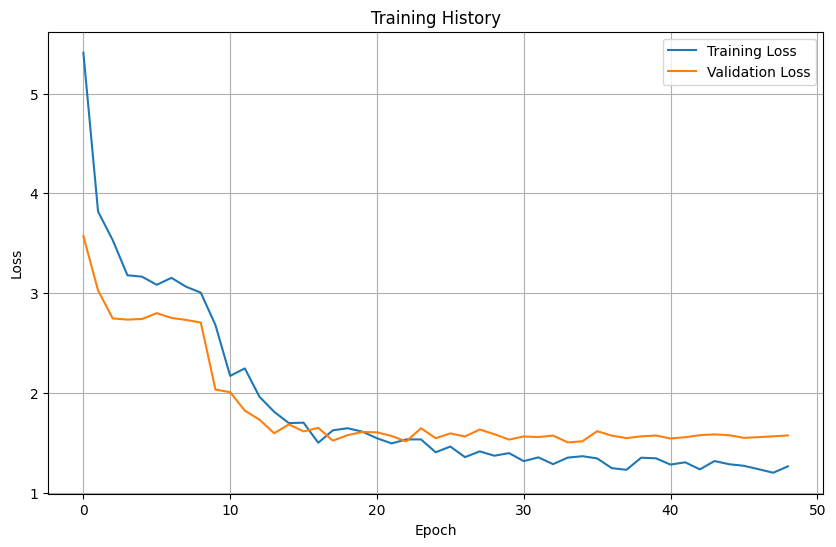


Making predictions...

MATCH PREDICTIONS
Home Team                 Away Team                 Score      Result         
--------------------------------------------------------------------------------
Blackburn Rovers          Sheffield United          0 - 1      Sheffield United win
Oxford United             Swansea City              0 - 0      Draw           
Stoke City                Derby County              0 - 0      Draw           
Cardiff City              Norwich City              0 - 0      Draw           
Hull City                 Portsmouth FC             0 - 0      Draw           
Leeds United              Plymouth Argyle           0 - 0      Draw           
Middlesbrough FC          Coventry City             0 - 0      Draw           
Preston North End         Bristol City              0 - 1      Bristol City win
Queens Park Rangers       Sunderland AFC            0 - 0      Draw           
Sheffield Wednesday       Watford FC                0 - 0      Draw           
--

In [38]:
# ===================== Run the predictor =====================
if __name__ == "__main__":
    # Run main function
    model, scaler, team_to_id, df, elo_ratings, feature_columns = main()
    
    # Optional: Generate full league table prediction
    # Uncomment the line below to generate predictions for all possible fixtures
    league_table = generate_league_table(model, scaler, team_to_id, df, elo_ratings, feature_columns)
    
    # Optional: Analyze specific team
    analyze_team_performance('Sunderland', df)
    
    # Optional: Cross-validation
    X, y, _, _ = preprocess_data(df)
    fold_results, _ = cross_validate_model(X, y, team_to_id)

In [40]:

    # Optional: Analyze specific team
    analyze_team_performance('Sunderland', df)


ANALYSIS: Sunderland

Historical Performance:
Total Matches: 38
Record: 19W - 12D - 7L
Goals: 55 for, 37 against (GD: +18)
Points: 69 (PPG: 1.82)

Home: 11W - 7D - 1L (31 GF, 15 GA)
Away: 8W - 5D - 6L (24 GF, 22 GA)

Last 10 Games: D W D W L L W W D L
Recent Form: 15 points from last 10 games
